**Brian Blaylock**  
**May 31, 2019**

# How Fractions Skill Score (FSS) works

Hopefully this helps explain what FSS is, how it is calculated, and the meaning of a useful forecast (FSS_uniform).

FSS was introduced by Nigel Roberts and Humphrey Lean in 2008. It is a verification method that describes skill between forecasts and observed binary conditions as a fraction of area within a neighborhood of grid points.

> Roberts, N.M. and H.W. Lean, 2008: Scale-Selective Verification of Rainfall Accumulations from High-Resolution Forecasts of Convective Events. Mon. Wea. Rev., 136, 78–97, https://doi.org/10.1175/2007MWR2123.1  

Other References
> Wolff, J.K., M. Harrold, T. Fowler, J.H. Gotway, L. Nance, and B.G. Brown, 2014: Beyond the Basics: Evaluating Model-Based Precipitation Forecasts Using Traditional, Spatial, and Object-Based Methods. _Wea. Forecasting_, **29**, 1451–1472, https://doi.org/10.1175/WAF-D-13-00135.1

> Skok, G., 2016: Analysis of Fraction Skill Score properties for a displaced rainy grid point in a rectangular domain. _Atmospheric Research_, **169**, 556-565, https://doi.org/10.1016/j.atmosres.2015.04.012

> Mittermaier, M., and N. Roberts, 2010: Intercomparison of Spatial Forecast Veriﬁcation Methods: Identifying Skillful Spatial Scales Using the Fractions Skill Score. _Weather and Forecasting_, **25**, 343-354, http://doi.org/10.1175/2009WAF2222260.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Convert to binary fields
Generate two grids of binary fields, 1) where the conditon was observed and 2) where the condition was forecasted.

Most studies have used this for precipitation verification. I am using FSS to evalutate lightning forecasts--a True/False grid for where lightning was observed and another True/False grid for where lightning was forecasted.

## 2. Generate Fractions based on neighborhood
Next, you determine a scale to evaluate with grid points within a neighborhood (*n*). The easiest neighborhood is a square, but you may also use a circular neighborhood (which I did for my paper).

For _every_ grid point in the observed and forecasted binary field, consider all the points within the neighborhood and compute the fraction of points where the condintion is met. This will create two new fields with values ranging from 0 to 1.

- **`O(n)i,j`** is the field of fractions for the observed binary field with neighborhood *n*.
- **`M(n)i,j`** is the field of fractions for the forecasted binary field with neighborhood *n*.

For example, below are the observed and forecasted neighborhoods for a single point, a neighborhood of 5 X 5.

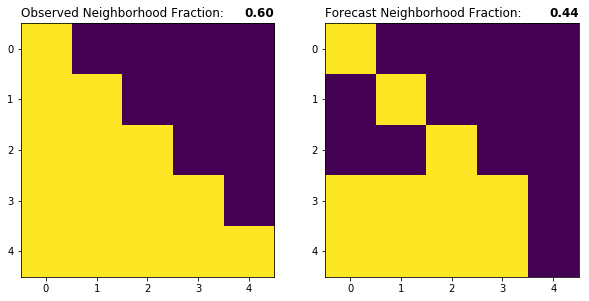

In [2]:
# Binary observation for neighborhood
OBS_n = [[1,0,0,0,0],
         [1,1,0,0,0],
         [1,1,1,0,0],
         [1,1,1,1,0],
         [1,1,1,1,1]]

# Binary forecasted for neighborhood
FXX_n = [[1,0,0,0,0],
         [0,1,0,0,0],
         [0,0,1,0,0],
         [1,1,1,1,0],
         [1,1,1,1,0]]

# Compute fraction of area (O and M for the point i,j)
frac_OBS = np.sum(OBS_n)/np.size(OBS_n)  # O_i,j
frac_FXX = np.sum(FXX_n)/np.size(FXX_n)  # M_i,j

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Observed Neighborhood Fraction:', loc='left')
ax1.set_title('%.2f' % frac_OBS, loc='right', fontweight='bold')
ax1.imshow(OBS_n, vmin=0, vmax=1)

ax2.set_title('Forecast Neighborhood Fraction:', loc='left')
ax2.set_title('%.2f' % frac_FXX, loc='right', fontweight='bold')
ax2.imshow(FXX_n, vmin=0, vmax=1);

**This is repeated for every grid point**: `O(n=5)` and `M(n=5)` for all `i` and `j`

This computation can easily be applied to every grid point with `scipy.ndimage.generic_filter`

    import scipy.ndimage as ndimage
    
    def fraction(values):
        return np.sum(values)/np.size(values)
     
     obs_fraction = ndimage.generic_filter(obs_binary, fraction, mode='constant', cval=0, size=5) 
     fxx_fraction = ndimage.generic_filter(fxx_binary, fraction, mode='constant', cval=0, size=5) 

# 3. Compute Fractions Skill Score (FSS)

To compute FSS, first, compute the Mean Square Error for the observed and forecast fractions. Nx and Ny simply refer to all grid points. 

$$MSE_{(n)} = \frac{1}{N_xN_y} \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{{[O_{(n)i,j} - M_{(n)i,j}]}^2}$$

> In python, this is simply: __MSE = np.mean((O-M)**2)__

_"The MSE is not in itself very useful because **it is highly dependent on the frequency of the event** itself"_ (Roberts and Lean 2008). Instead, FSS is computed relative to a low-skill reference forecast.`MSE_ref` is the the mean square error for a _completely random forecast_.

$$
MSE_{(n)ref} = \frac{1}{N_xN_y} 
\Bigg [ 
\sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{{O_{(n)i,j}^2} + \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{M^2_{(n)i,j}}
\Bigg ]}
$$

> In python, this is simply: __MSE_ref = np.mean(O******2) + np.mean(M******2)__

Finally, FSS is computed as follows:

$$FSS = 1- \frac{MSE_{(n)}}{MSE_{(n)ref}}$$


## Useful Forecast; FSS*uniform*

> **Wolf et al (2014)**: The forecast skill associated with a uniform forecast is also deﬁned by Roberts and Lean (2008) as the FSS that would be obtained at the grid scale (i.e., n 5 1) for a forecast with a probability equal to the base rate at every point (FSSuniform 5 0.5 1 base rate/2). Here, the base rate is the fraction of the domain covered by the observed precipitation exceeding the threshold. The FSSuniform value falls approximately halfway between the random forecast skill (deﬁned as the base rate, or fractional coverage of the domain) and perfect skill and is considered to be a reasonably skillful forecast at the lower bound of the useful spatial scales...The uniform forecast skill is an important indicator of the scale at which the forecast becomes useful...The two highest precipitation thresholds of 6.35 and 8.89mm are always associated with FSS values less than the calculated uniform forecast skill for both models regardless of spatial scale or forecast lead time.

> **Skok (2016)**: The useful forecast criteria (_FSSuseful_) is defined as a value of FSS for a precipitation feature with a displacement half the neighborhood size. _FSSuseful_ for a displaced rainy grid point depends on the orientation of the displacement being the largest for displacements that are parallel to the borders and the smallest for a diagonal displacement for which the value can be as low as 0.42

> **Mittermaier and Robets (2010)**:  Roberts and Lean (2008) show how we can derive a skillful spatial scale, L(FSS > 0.5 + _f_/2), where **_f_ is the observed** fractional rainfall coverage over the domain (wet-area ratio). This represents a lower limit of useful scales. If _f_ is not very large (and it typically is not for a large domain), a value of 0.5 can be used as a lower limit. Note that there is still some skill below 0.5 as a random forecast has skill equal to _f_. The upper limit of such useful scales is less easily deﬁned and may well depend on the forecast application....  
...If there is no overlap between the forecast and observed ﬁelds at the grid scale, then the FSS is zero. If the forecast is misplaced spatially, but otherwise good, then the FSS will increase with neighborhood size and exceed 0.5 (or 0.5 1 f/2 for large f) at a scale that can be called skillful. If the forecast is poor,thescore is small, and mayremain constant with increasing neighborhood size if there is a signiﬁcant bias, potentially never attaining a skillful spatial scale L(FSS . 0.5)...  
...The L(FSS > 0.5 + f/2) distance gives an indirect measure of quality and value to the user. Although the concept of equitability cannot be considered in the strictest sense, the FSS does appear to produce a consistently low score for poor forecasts (that would be expected to score badly). Results also seem to suggest that the FSS cannot be hedged or improved through changing the bias. If anything, the score decreases as the forecasts are more biased. Finally, operational users are seeing the potential of the ‘‘skillful’’ spatial scale as a veriﬁcation metric. Although it is not a skill score, it is easy to understand for the forecast user, model developer,and statistician alike.


A useful forecast is defined where FSS > FSS_uniform

$$FSS_{uniform} = 0.5 + BaseRate/2$$

---

## Example FSS Calculation

NOTE: `BaseRate` is the fraction of area the condition was observed.

In [31]:
def print_and_plot_FSS(O, M, plot=True, verbose=True):
    """
    Compute FSS from the O and M grids, create a plot, and print the stats
        O - Observed fractions grid
        M - Forecast fractions grid
    """
    MSE = np.mean((O-M)**2)
    MSE_ref = np.mean(O**2 + M**2)
    FSS = 1 - (MSE/MSE_ref)

    # You can *roughly* caluculate the BaseRate from the Observed Fractions (if domain is sufficiently large; assumes domain is outlines by zeros)
    BaseRate=np.sum(O)/np.size(O)
    FSS_uniform = 0.5 + BaseRate/2
    
    if FSS>FSS_uniform:
        useful = '    Useful :)'
    else:
        useful = '    NOT useful'
    
    if verbose:
        print('MSE        :  %.3f' % MSE)
        print('MSE_ref    :  %.3f' % MSE_ref, '      Base Rate: %.3f' % BaseRate)
        print('----------------------------------------')
        print('FSS        :  %.3f' % FSS,     '    FSS_uniform: %.3f' % FSS_uniform, useful)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.set_title('Observed Fractions : O(n)ij', loc='left')
        img_obs = ax1.imshow(O, vmin=0, vmax=1)
        plt.colorbar(img_obs, ax=ax1, shrink=.8)

        ax2.set_title('Forecast Fractions : M(n)ij', loc='left')
        img_fxx = ax2.imshow(M, vmin=0, vmax=1)
        plt.colorbar(img_fxx, ax=ax2, shrink=.8);
    
    return (MSE, MSE_ref, FSS, BaseRate, FSS_uniform)

### A Completely Random Forecast and Observation

MSE        :  0.166
MSE_ref    :  0.667       Base Rate: 0.500
----------------------------------------
FSS        :  0.750     FSS_uniform: 0.750     Useful :)


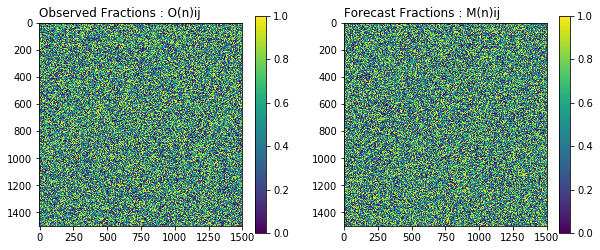

In [32]:
# Completely Random Observed and Forecast fractions...

size = 1500

O_this = np.random.rand(size,size)
M_this = np.random.rand(size,size)

data = print_and_plot_FSS(O_this, M_this)

### FSS etc. for random `O(n)ij` and `M(n)ij` with increasing domain size

Test lots of domain sizes to see FSS for random forecasts and observation grids wid different domain sizes.

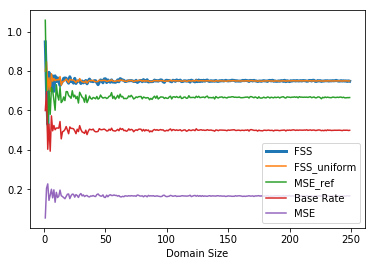

In [5]:
sizes = range(1, 250)

# Compute FSS, etc., for each domain size
lots = np.array([print_and_plot_FSS(np.random.rand(s,s), np.random.rand(s,s), plot=False, verbose=False) for s in sizes])

# unpack stats from returned array
MSE = lots[:,0]
MSE_ref = lots[:,1]
FSS = lots[:,2]
BaseRate = lots[:,3]
FSS_uniform = lots[:,4]


plt.plot(sizes,FSS, label='FSS', lw=3)
plt.plot(sizes,FSS_uniform, label='FSS_uniform')
plt.plot(sizes,MSE_ref, label='MSE_ref')
plt.plot(sizes,BaseRate, label='Base Rate')
plt.plot(sizes,MSE, label='MSE')

plt.legend()

plt.xlabel('Domain Size');

---
### Special/Specific Case Examples

#### Perfect Forecast
FSS == 1

MSE        :  0.000
MSE_ref    :  0.104       Base Rate: 0.065
----------------------------------------
FSS        :  1.000     FSS_uniform: 0.533     Useful :)


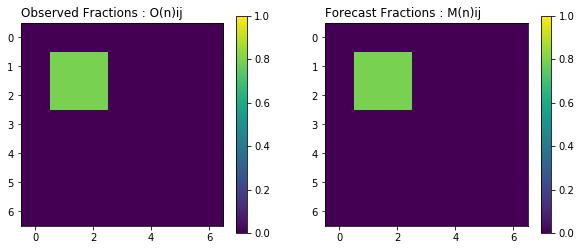

In [6]:
OBS = np.array([[.0,.0,.0,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0]])

FXX = np.array([[.0,.0,.0,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### Almost perfect Forecast

MSE        :  0.020
MSE_ref    :  0.102       Base Rate: 0.065
----------------------------------------
FSS        :  0.803     FSS_uniform: 0.533     Useful :)


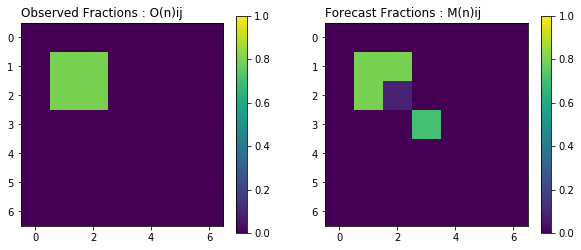

In [7]:
OBS = np.array([[.0,.0,.0,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0]])

FXX = np.array([[.0,.0,.0,.0,.0,.0,.0],
                [.0,.8,.8,.0,.0,.0,.0],
                [.0,.8,.1,.0,.0,.0,.0],
                [.0,.0,.0,.7,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

MSE        :  0.054
MSE_ref    :  0.216       Base Rate: 0.132
----------------------------------------
FSS        :  0.752     FSS_uniform: 0.566     Useful :)


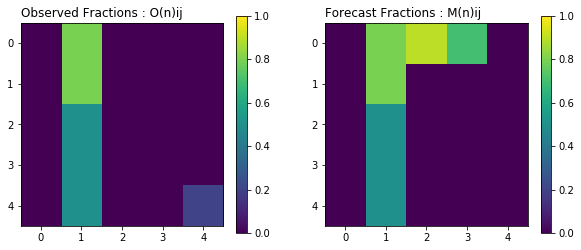

In [8]:
OBS = np.array([[.0,.8,.0,.0,.0],
                [.0,.8,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.2]])

FXX = np.array([[.0,.8,.9,.7,.0],
                [.0,.8,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### "FSS is influenced by the frequency bias" (Mittermaier and Roberts 2010)
In this example, the forecast didn't forecast as much as was observed, but where it did forecast it got it perfectly right. Still, this is a bad forecast.

MSE        :  0.242
MSE_ref    :  0.508       Base Rate: 0.440
----------------------------------------
FSS        :  0.524     FSS_uniform: 0.720     NOT useful


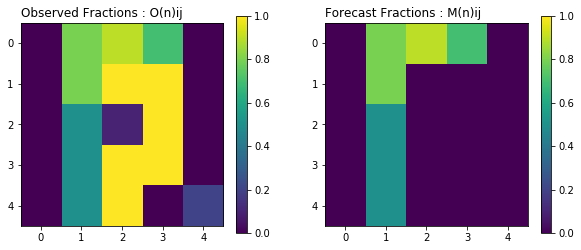

In [30]:
OBS = np.array([[.0,.8,.9,.7,.0],
                [.0,.8,1.,1.,.0],
                [.0,.5,.1,1.,.0],
                [.0,.5,1.,1.,.0],
                [.0,.5,1.,.0,.2]])

FXX = np.array([[.0,.8,.9,.7,.0],
                [.0,.8,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.0],
                [.0,.5,.0,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### No rain observed, but a little forecasted, is not useful.
To get FSS values > 0, there must be some overlap in the fields.

MSE        :  0.051
MSE_ref    :  0.051       Base Rate: 0.000
----------------------------------------
FSS        :  0.000     FSS_uniform: 0.500     NOT useful


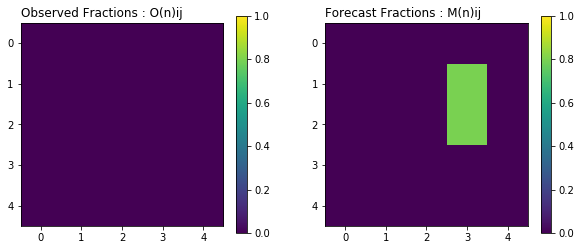

In [42]:
OBS = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,0.,0.,.0],
                [.0,.0,.0,0.,.0],
                [.0,.0,0.,0.,.0],
                [.0,.0,0.,.0,.0]])

FXX = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,.0,.8,.0],
                [.0,.0,.0,.8,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### Few observations no forecast, also not useful.

MSE        :  0.051
MSE_ref    :  0.051       Base Rate: 0.064
----------------------------------------
FSS        :  0.000     FSS_uniform: 0.532     NOT useful


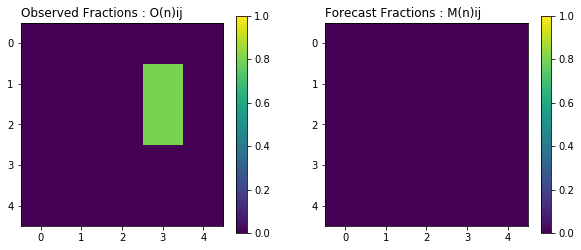

In [41]:
OBS = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,.0,.8,.0],
                [.0,.0,.0,.8,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0]])

FXX = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,0.,0.,.0],
                [.0,.0,.0,0.,.0],
                [.0,.0,0.,0.,.0],
                [.0,.0,0.,.0,.0]])


data = print_and_plot_FSS(OBS, FXX)

MSE        :  0.115
MSE_ref    :  0.144       Base Rate: 0.120
----------------------------------------
FSS        :  0.200     FSS_uniform: 0.560     NOT useful


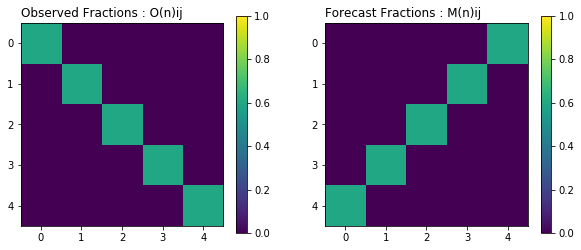

In [73]:
OBS = np.array([[.6,.0,.0,.0,.0],
                [.0,.6,.0,.0,.0],
                [.0,.0,.6,.0,.0],
                [.0,.0,.0,.6,.0],
                [.0,.0,.0,.0,.6]])

FXX = np.array([[.0,.0,.0,.0,.6],
                [.0,.0,0.,.6,.0],
                [.0,.0,.6,0.,.0],
                [.0,.6,0.,.0,.0],
                [.6,.0,0.,.0,.0]])


data = print_and_plot_FSS(OBS, FXX)

#### FSS is NAN if there is no conditions observed or forecasted
This sould be classified as a useful forecast :)

MSE        :  0.030
MSE_ref    :  0.030       Base Rate: 0.000
----------------------------------------
FSS        :  0.000     FSS_uniform: 0.500     NOT useful


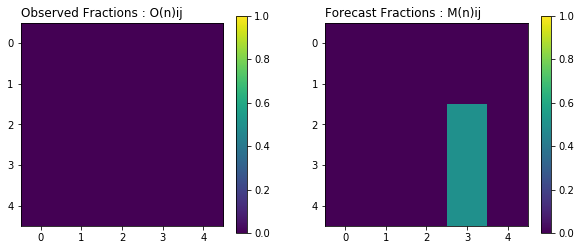

In [84]:
OBS = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0],
                [.0,.0,.0,.0,.0]])

FXX = np.array([[.0,.0,.0,.0,.0],
                [.0,.0,0.,0.,.0],
                [.0,.0,.0,0.5,.0],
                [.0,.0,0.,0.5,.0],
                [.0,.0,0.,0.5,.0]])


data = print_and_plot_FSS(OBS, FXX)

#### No overlap forecast
Not skillful, obviously

> **Mittermaier and Roberts (2010)**: ...if there is no overlap between the forecast and observed ﬁelds at the grid scale,then the FSS is zero.

MSE        :  0.810
MSE_ref    :  0.810       Base Rate: 0.720
----------------------------------------
FSS        :  0.000     FSS_uniform: 0.860     NOT useful


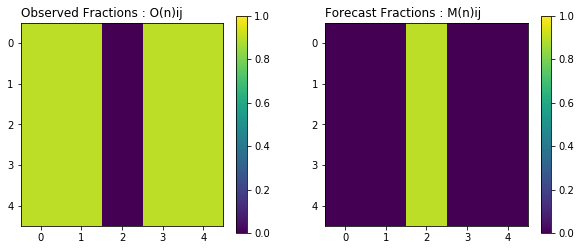

In [9]:
OBS = np.array([[.9,.9,.0,.9,.9],
                [.9,.9,.0,.9,.9],
                [.9,.9,.0,.9,.9],
                [.9,.9,.0,.9,.9],
                [.9,.9,.0,.9,.9]])

FXX = np.array([[.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### Shifted forecast (NOTE: not a shifted feature, but a shift in the O and M fields)
Not skillful becuase the feature is shifted more than the allowed "scale"

MSE        :  0.324
MSE_ref    :  0.324       Base Rate: 0.180
----------------------------------------
FSS        :  0.000     FSS_uniform: 0.590     NOT useful


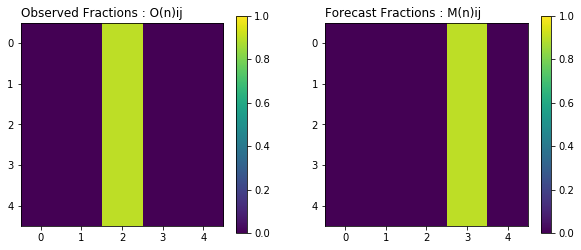

In [10]:
OBS = np.array([[.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0],
                [.0,.0,.9,.0,.0]])

FXX = np.array([[.0,.0,.0,.9,.0],
                [.0,.0,.0,.9,.0],
                [.0,.0,.0,.9,.0],
                [.0,.0,.0,.9,.0],
                [.0,.0,.0,.9,.0]])

data = print_and_plot_FSS(OBS, FXX)

#### Observed half the domain
- Half the points are observed (Base Rate == 0.5)
- Quarter of the points are forecasted (Forecast Rate == 0.25)


FSSuniform is 0.75 (half way between a random forecast with same forecast rate and perfect forecast).

FSS is 0.8, and is a useful forecast becuase FSS > FSSuniform

MSE        :  0.062
MSE_ref    :  0.312       Base Rate: 0.500
----------------------------------------
FSS        :  0.800     FSS_uniform: 0.750     Useful :)


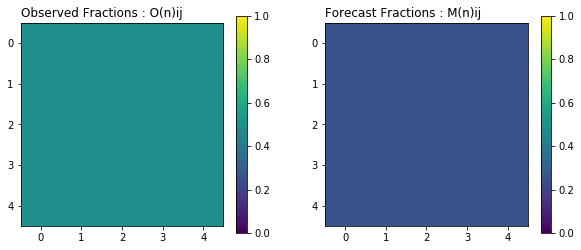

In [82]:
OBS = np.array([[.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5]])

FXX = np.array([[.25,.25,.25,.25,.25],
                [.25,.25,.25,.25,.25],
                [.25,.25,.25,.25,.25],
                [.25,.25,.25,.25,.25],
                [.25,.25,.25,.25,.25]])


data = print_and_plot_FSS(OBS, FXX)

#### Observed Everywhere
Since the feature is observed everywhere, the Base Rate is 1, and FSS_uniform is 1. Thus, only a forecast that also forecasts the condition everywhere is useful.

MSE        :  0.080
MSE_ref    :  1.920       Base Rate: 1.000
----------------------------------------
FSS        :  0.958     FSS_uniform: 1.000     NOT useful


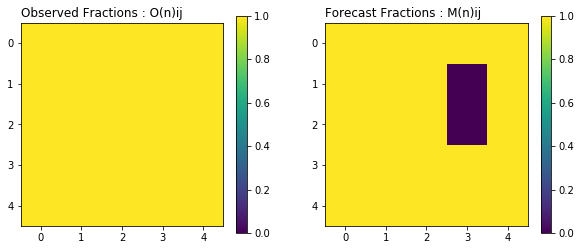

In [11]:
OBS = np.array([[1,1,1,1,1],
                [1,1,1,1,1],
                [1,1,1,1,1],
                [1,1,1,1,1],
                [1,1,1,1,1]])

FXX = np.array([[1,1,1,1,1],
                [1,1,1,0,1],
                [1,1,1,0,1],
                [1,1,1,1,1],
                [1,1,1,1,1]])

data = print_and_plot_FSS(OBS, FXX)

----

Some FSS characteristics:
- FSS range from 0 to 1.
    - 1 is perfect forecast; when MSE == 0 and forecast is unbiased.
    - 0 is "no skill"
- Skill asomptopes depends on the forecast bias. For an unbiased forecast, FSS asomptopes to 1 with increasing *n*.

- If BaseRate is high (lots of lightning observed) then FSS must be _much_ larger than 0.5 if forecasts are to be "useful".
- If BaseRate is low (few lightning observed) then FSS must be greater than 0.5 if forecast is to be "useful". 

- A perfect forecast is acheived when MSE approaches zero, or when there is no error between the O and M fractional grids.

- 

---
> Abreviations
- `n` : the neighborhood size used to compute fractional areas
- `O(n)ij`: Fraction of neighborhood with observed condition at every grid point
- `M(n)ij`: Fraction of neighborhood with forecasted condition at every grid point
- `Nx Ny`: Every grid point in the domain
- `MSE`: Mean Square Error
- `MSE_ref`: skill of a completely random forecast
- `FSS`: Fractions Skill Score
- `BaseRate`: Fraction of area where the condition was observed
- `FSS_uniform`: A useful forecast is FSS > .5 + BaseRate/2

---

# Real Example: HRRR Simulated Reflectivity
For the purpose of this demo, the "observed" field will be the HRRR analysis F00.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import ndimage

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_maps.my_basemap import draw_HRRR_map

m = draw_HRRR_map()

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


### Download Data

In [13]:
validDATE = datetime(2019, 5, 1)
fxx = 12

Analysis = get_hrrr_variable(validDATE, variable='REFC:entire')
Forecast = get_hrrr_variable(validDATE-timedelta(hours=fxx), variable='REFC:entire', fxx=fxx)


 >> Dowloading tempfile: ./temp_hrrr_2019050100_f00_REF.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190501/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190501/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  1:0:d=2019050100:REFC:entire atmosphere:anl:
 >> Byte Range: 0 562678
  Run Date: 2019-05-01 00:00 UTC F00
Valid Date: 2019-05-01 00:00 UTC

 >> Dowloading tempfile: ./temp_hrrr_2019043012_f12_REF.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190430/hrrr.t12z.wrfsfcf12.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190430/hrrr.t12z.wrfsfcf12.grib2.idx
 >> Matched a variable:  1:0:d=2019043012:REFC:entire atmosphere:12 hour fcst:
 >> Byte Range: 0 600338
  Run Date: 2019-04-30 12:00 UTC F12
Valid Date: 2019-05-01 00:00 UTC


### 1. Generate Binary Fields

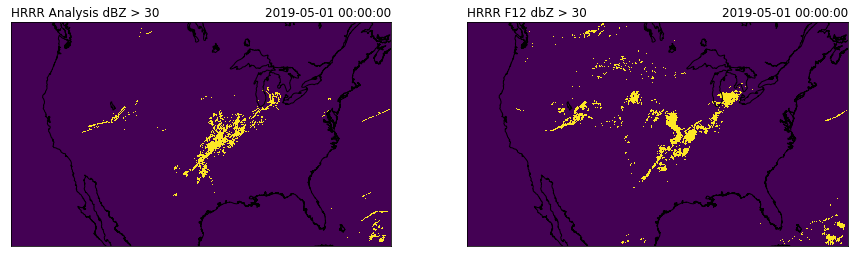

In [14]:
threshold = 30  # dBz

binary_anl = Analysis['value'].data > threshold
binary_fxx = Forecast['value'].data > threshold

# Convert values from boolean to 1 or 0
binary_anl = np.array(binary_anl, dtype=float)
binary_fxx = np.array(binary_fxx, dtype=float)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(Analysis['lon'], Analysis['lat'], binary_anl, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR Analysis dBZ > %s' % threshold, loc='left'); plt.title(validDATE, loc='right')

plt.sca(ax2)
m.pcolormesh(Analysis['lon'], Analysis['lat'], binary_fxx, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR F%02d dbZ > %s' % (fxx, threshold), loc='left'); plt.title(validDATE, loc='right');

### 2. Generate Fractions
Note: the large the size of the neighborhood, the longer it takes to run the filter.

In [15]:
def fraction(values):
    return np.sum(values)/np.size(values)

In [16]:
n = 10  # Define size of square neighborhood 

fraction_anl = ndimage.generic_filter(binary_anl, fraction, mode='constant', cval=0, size=n) 
fraction_fxx = ndimage.generic_filter(binary_fxx, fraction, mode='constant', cval=0, size=n)

NOTE: Circular neighborhoods are also easy. You can customize a ndimage.generic_filter footprint...
    
    def radial_footprint(radius):
        """A footprint with the given radius"""
        y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
        footprint = x**2+y**2 <= radius**2
        footprint = 1*footprint.astype(float)
        return footprint
        
     ndimage.generic_filter(obs_binary, fraction, footprint=radial_footprint(5), mode='constant', cval=0)

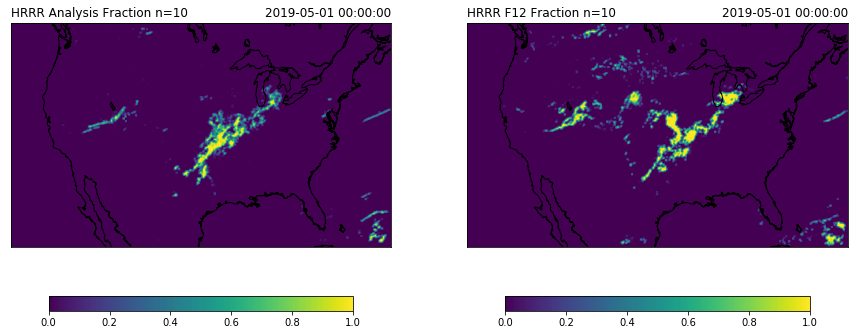

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,6])
plt.sca(ax1)
m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_anl, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR Analysis Fraction n=%s' % n, loc='left'); plt.title(validDATE, loc='right')
plt.colorbar(orientation='horizontal', shrink=.8)

plt.sca(ax2)
m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_fxx, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR F%02d Fraction n=%s' % (fxx, n), loc='left'); plt.title(validDATE, loc='right');
plt.colorbar(orientation='horizontal', shrink=.8);

### 3. Compute Fractions Skill Score (FSS)

In [18]:
MSE = np.mean((fraction_anl - fraction_fxx)**2)
MSE_ref = np.mean(fraction_anl**2) + np.mean(fraction_fxx**2)
FSS = 1 - (MSE/MSE_ref)

BaseRate = np.sum(binary_anl)/np.size(binary_anl)
FSS_uniform = .5 + BaseRate/2


if FSS>FSS_uniform:
    useful = '    Useful :)'
else:
    useful = '    NOT useful'


print('MSE        :  %.3f' % MSE)
print('MSE_ref    :  %.3f' % MSE_ref, '      Base Rate: %.3f' % BaseRate)
print('----------------------------------------')
print('FSS        :  %.3f' % FSS,     '    FSS_uniform: %.3f' % FSS_uniform, useful)

MSE        :  0.013
MSE_ref    :  0.025       Base Rate: 0.016
----------------------------------------
FSS        :  0.468     FSS_uniform: 0.508     NOT useful


---
### Show FSS for Multiple Neighborhood sizes

n         MSE       MSE_ref   FSS       Base Rate FSS_uniform    Useful?   
--------------------------------------------------------------------
1         0.029     0.041     0.28      0.016     0.51           NOT useful
5         0.018     0.03      0.39      0.016     0.51           NOT useful
10        0.013     0.025     0.47      0.016     0.51           NOT useful
20        0.0083    0.02      0.58      0.016     0.51           Useful :)


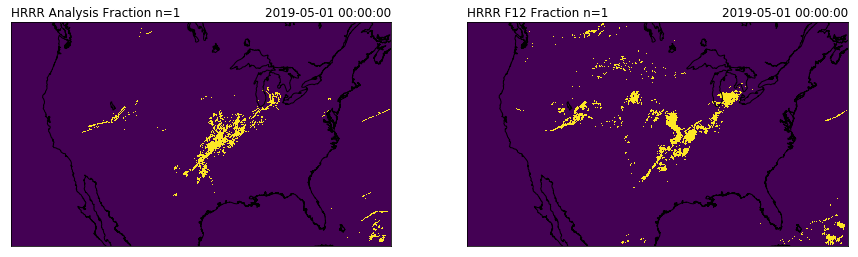

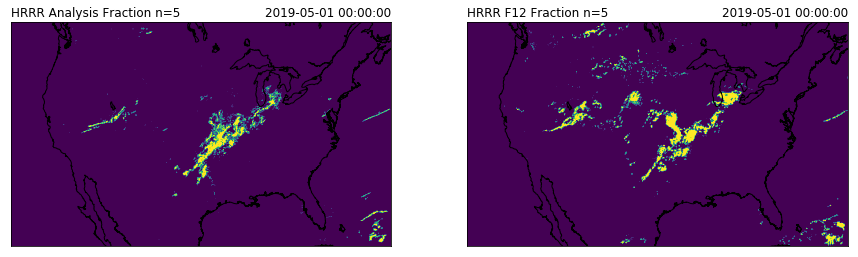

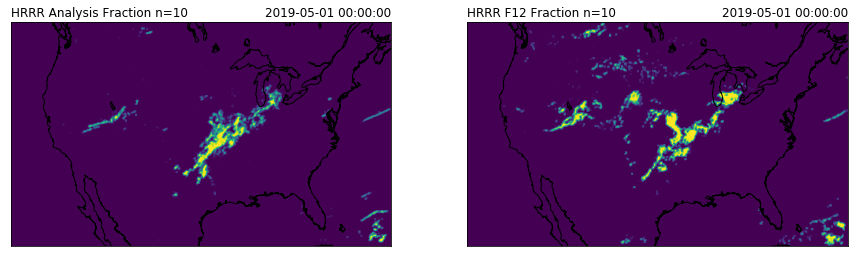

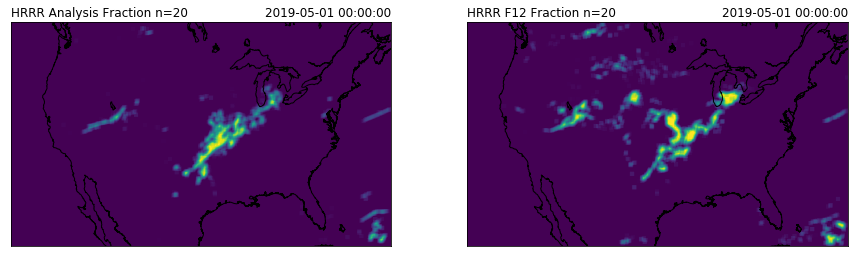

In [20]:
print('{:10}{:10}{:10}{:10}{:10}{:15}{:10}'.format('n', 'MSE', 'MSE_ref', 'FSS', 'Base Rate', 'FSS_uniform', 'Useful?'))
print('-------------------------------------------------------------------------')

for n in [1, 5, 10, 20]:
    fraction_anl = ndimage.generic_filter(binary_anl, fraction, mode='constant', cval=0, size=n) 
    fraction_fxx = ndimage.generic_filter(binary_fxx, fraction, mode='constant', cval=0, size=n)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
    plt.sca(ax1)
    m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_anl, latlon=True, vmin=0, vmax=1)
    m.drawcoastlines()
    plt.title('HRRR Analysis Fraction n=%s' % n, loc='left'); plt.title(validDATE, loc='right')

    plt.sca(ax2)
    m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_fxx, latlon=True, vmin=0, vmax=1)
    m.drawcoastlines()
    plt.title('HRRR F%02d Fraction n=%s' % (fxx, n), loc='left'); plt.title(validDATE, loc='right');

    MSE = np.mean((fraction_anl - fraction_fxx)**2)
    MSE_ref = np.mean(fraction_anl**2) + np.mean(fraction_fxx**2)

    FSS = 1 - (MSE/MSE_ref)
    BaseRate = np.sum(binary_anl)/np.size(binary_anl)
    FSS_uniform = .5 + BaseRate/2

    if FSS>FSS_uniform:
        useful = 'Useful :)'
    else:
        useful = 'NOT useful'
    
    print('{:<10}{:<10.2}{:<10.2}{:<10.2}{:<10.2}{:<15.2}{:}'.format(n, MSE, MSE_ref, FSS, BaseRate, FSS_uniform, useful))